Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Parsed time range: 2022-03-21 00:00:58+00:00 – 2022-03-21 01:05:11+00:00


<ipython-input-9-c4a33b62c485>:63: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['cache'] = df.groupby('cid')['cache'].transform(lambda x: x.ffill().bfill())



Number of rows with content_type == 'other': 130
Showing up to 10 sample rows marked as 'other':
 Unnamed: 0             ip                      time  op                                                                                          target     http  status  body_bytes  request_length  request_time upstream_response_time upstream_header_time   cache          http_refer                                                                                                          http_user_agent      server_name                                                                  http_host  scheme                                                         cid     continent       country        regions     lat      long extension content_type
       2141 107.155.254.82 2022-03-21 00:01:16+00:00 GET          /ipfs/QmTjA6QFEVrz5ynfDDsUCQovhjjQiLpzGE1qrjSjWbQYAE/unrevealed.json3204?1647820875853 HTTP/1.1     404         179             206         0.006              ['0.004']            ['0.004

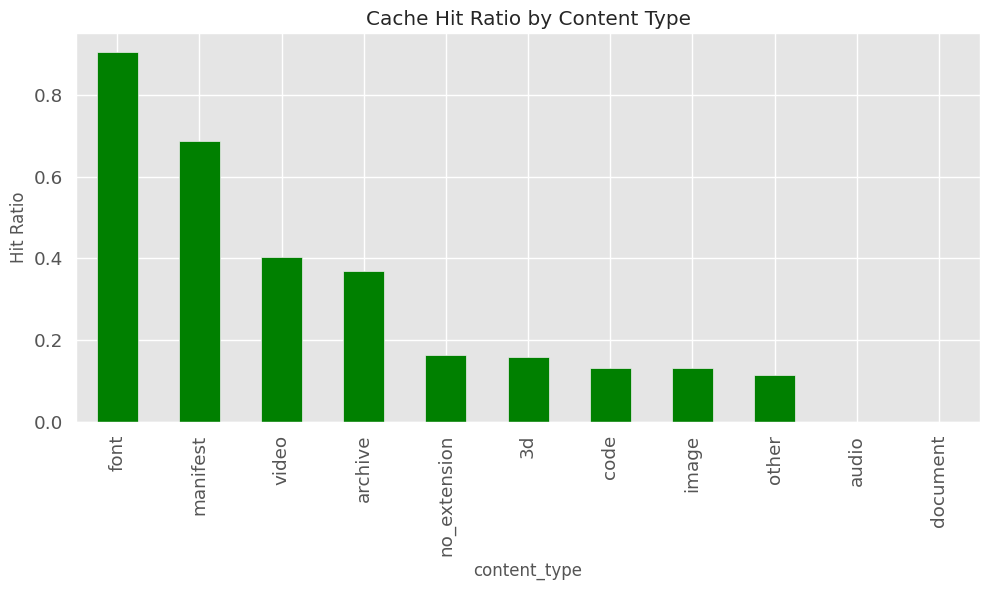

Top 3 types: {'font': 0.905982905982906, 'manifest': 0.6881443298969072, 'video': 0.4026548672566372}
Bottom 3 types: {'audio': 0.0, 'document': 0.0, 'other': 0.11538461538461539}

-- Hit/Miss Distribution for Top 15 Extensions (UNKNOWN filtered) --


<Figure size 1200x600 with 0 Axes>

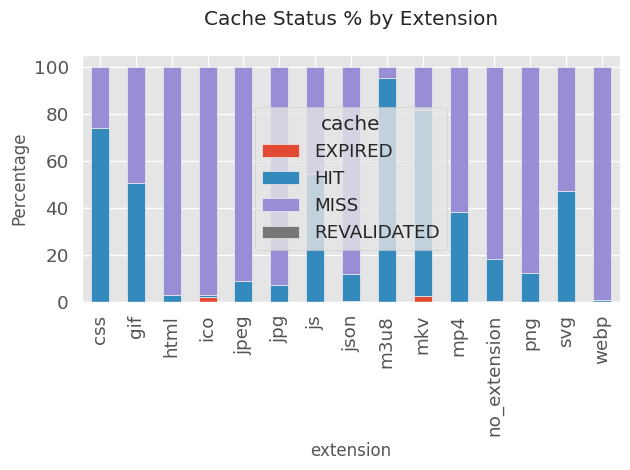

Highest MISS% extension: webp = 99.36%

-- Cache Hit Ratio by File Size --
Hit ratio variation with payload size.



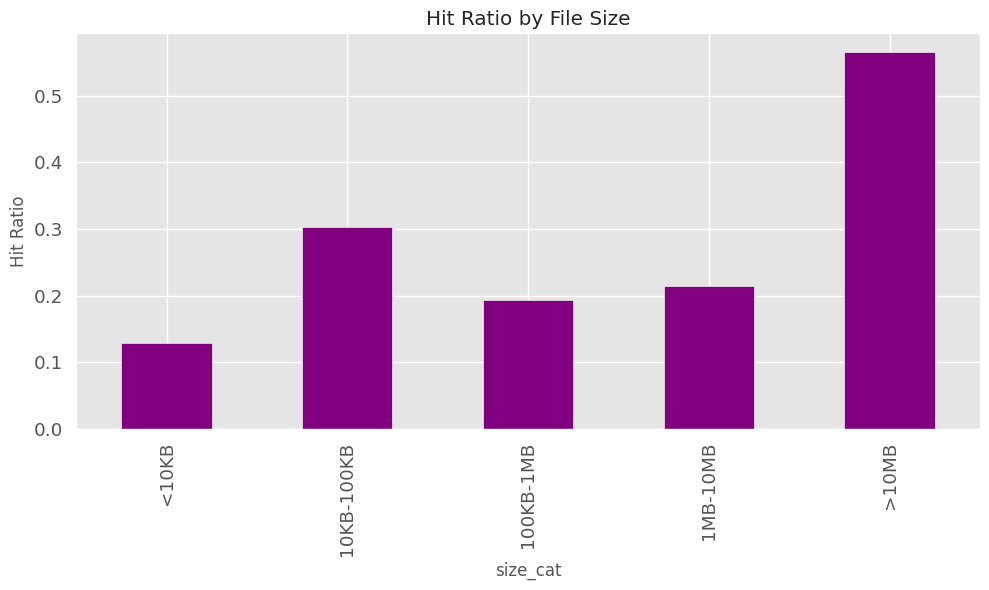


Size→hit correlation: 0.116

-- Cache Hit Ratio by Country (Overall & by Content Type) --


<ipython-input-9-c4a33b62c485>:205: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x['cache'] == 'HIT').mean())


<Figure size 1200x600 with 0 Axes>

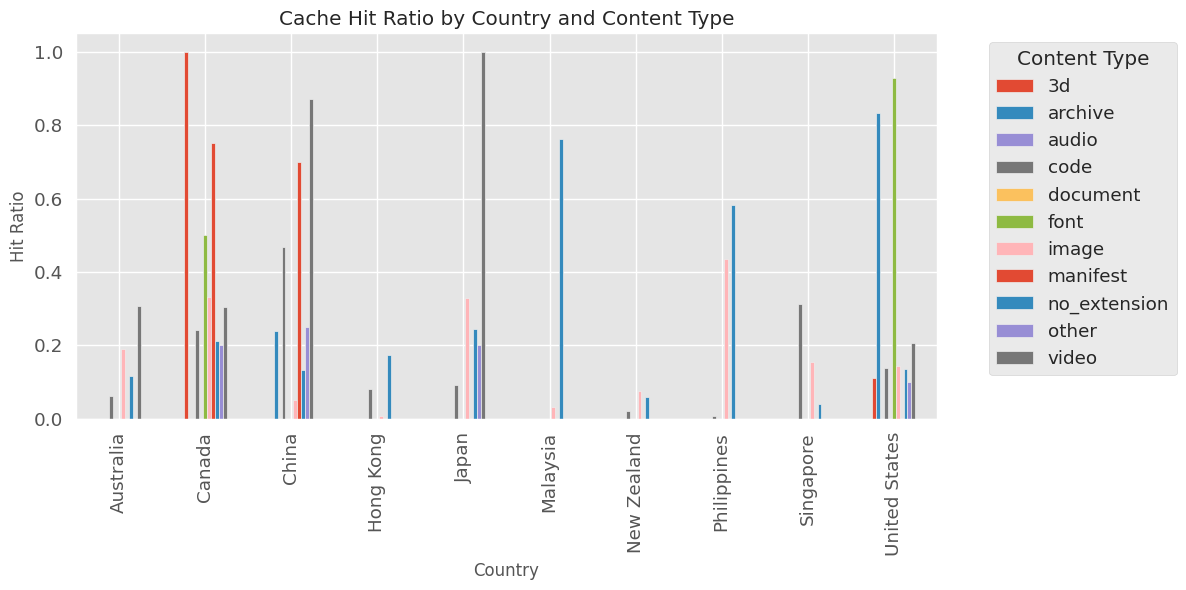


-- Avg Request Time by Content Type & Cache Status --


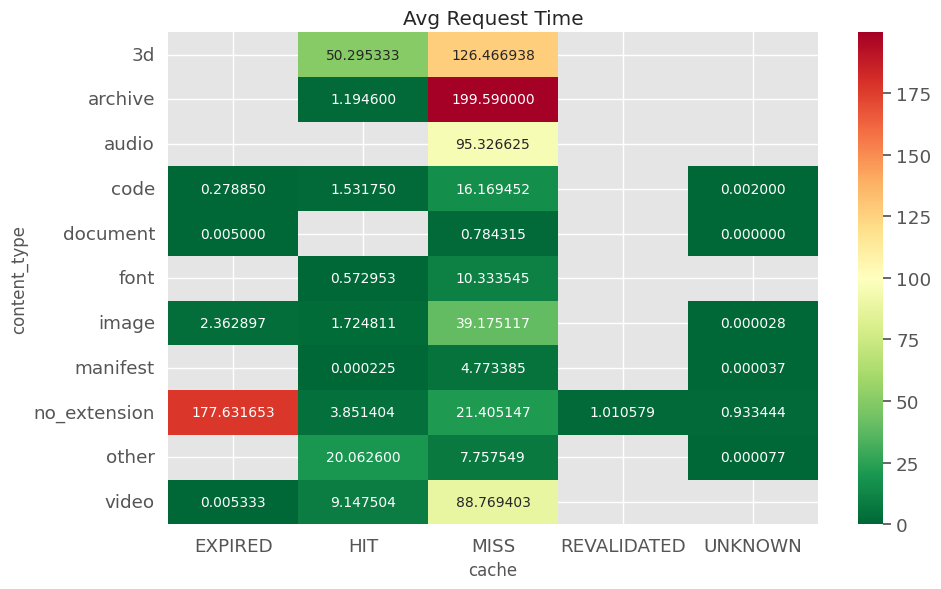


-- Cache Optimization Opportunities --
Candidates:
 cache  content_type     extension  total_requests  hit_ratio
11             code          html             195   0.030769
13             code          json           21709   0.113363
15             code           xml              12   0.000000
17         document           txt              89   0.000000
18             font           ttf               8   0.000000
21            image           ico            1793   0.008366
22            image          jpeg             312   0.086538
23            image           jpg            6419   0.073376
24            image           png           29671   0.123016
26            image          webp             156   0.006410
28     no_extension  no_extension          128891   0.163347
41            other            io               8   0.000000


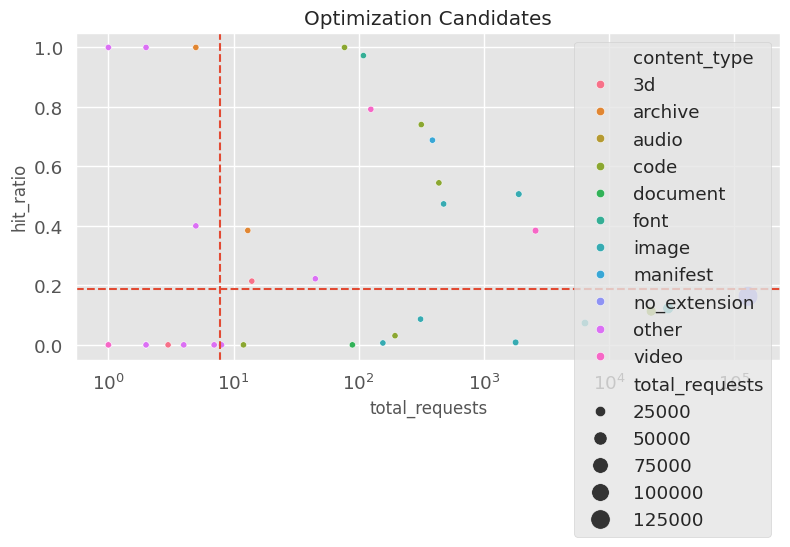


-- Cache Optimization Opportunities --
Candidates:
 cache  content_type     extension  total_requests  hit_ratio
11             code          html             195   0.030769
13             code          json           21709   0.113363
15             code           xml              12   0.000000
17         document           txt              89   0.000000
18             font           ttf               8   0.000000
21            image           ico            1793   0.008366
22            image          jpeg             312   0.086538
23            image           jpg            6419   0.073376
24            image           png           29671   0.123016
26            image          webp             156   0.006410
28     no_extension  no_extension          128891   0.163347
41            other            io               8   0.000000


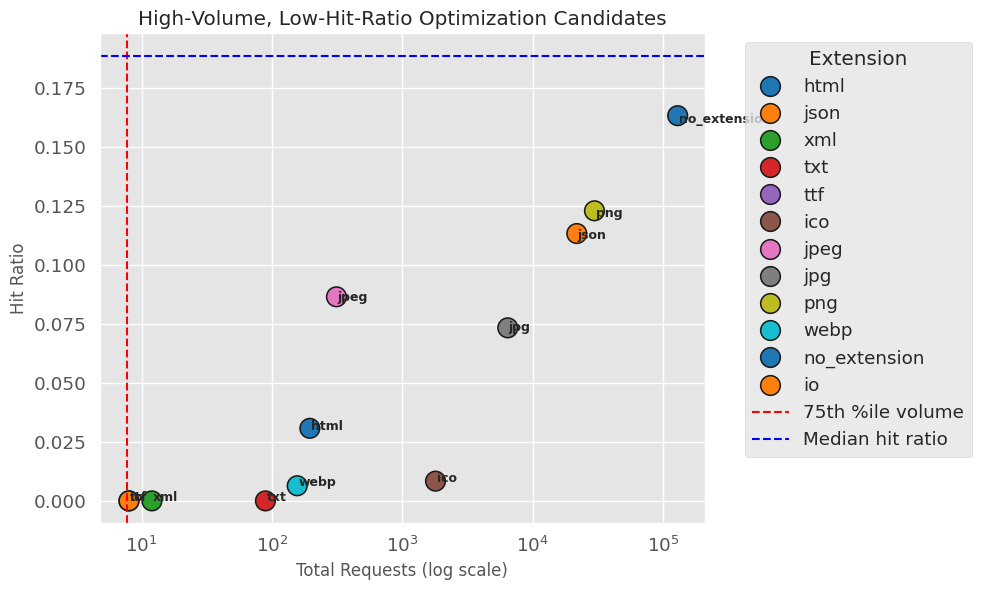

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from urllib.parse import urlparse
import os
from collections import Counter
import matplotlib.dates as mdates
from datetime import datetime

sns.set(font_scale=1.2)
plt.style.use('ggplot')


def load_and_preprocess_data(file_path):
    try:
        df = pd.read_csv(file_path)

        # Parse time
        if 'time' in df.columns:
            df['time'] = pd.to_datetime(df['time'].astype(str).str.strip('[]'), errors='coerce')
            print(f"Parsed time range: {df['time'].min()} – {df['time'].max()}")

        # Normalize cache
        if 'cache' in df.columns:
            df['cache'] = df['cache'].fillna('UNKNOWN').astype(str).str.lower()
            mapping = {
                '-':'UNKNOWN', '':'UNKNOWN',
                'hit':'HIT','miss':'MISS',
                'expired':'EXPIRED','revalidated':'REVALIDATED',
                'bypass':'BYPASS','updating':'UPDATING'
            }
            for old,new in mapping.items():
                df.loc[df['cache']==old, 'cache'] = new
            df['cache'] = df['cache'].str.upper()

        # Extract CID if missing
        if 'cid' not in df.columns:
            df['cid'] = df['target'].apply(
                lambda t: t.split('/ipfs/')[1].split('/')[0]
                if isinstance(t,str) and '/ipfs/' in t else np.nan
            )

        # Numeric conversions
        for col in ['body_bytes','request_length','request_time']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')

        return df

    except Exception as e:
        print(f"Error loading data: {e}")
        return None


def impute_missing_cache(df): #Impute UNKNOWN values for the cache
    df['cache'] = df['cache'].replace('UNKNOWN', np.nan)
    df = df.sort_values('time')
    df['cache'] = df.groupby('cid')['cache'].transform(lambda x: x.ffill().bfill())
    df['cache'] = df['cache'].fillna('UNKNOWN')
    return df


def extract_file_extension(target):
    if pd.isna(target) or not isinstance(target,str):
        return 'unknown'
    t = target.split('?')[0]
    fn = t.split('/ipfs/')[-1].split('/')[-1]
    if '.' in fn and len(fn.split('.')[-1])<10:
        return fn.split('.')[-1].lower()
    return 'no_extension'


def categorize_content_type(ext):
    fonts        = ['woff', 'woff2', 'ttf', 'otf', 'eot']
    manifests    = ['webmanifest', 'appcache', 'manifest', 'm3u8']
    graphics3d   = ['gltf', 'glb', 'obj', 'fbx', 'stl', 'dae', '3ds']
    image        = ['jpg', 'jpeg', 'png', 'gif', 'svg', 'webp', 'bmp', 'ico', 'tiff']
    video        = ['mp4', 'webm', 'avi', 'mov', 'mkv', 'flv', 'm4v', 'mpeg']
    audio        = ['mp3', 'wav', 'ogg', 'flac', 'm4a', 'aac']
    doc          = ['pdf', 'doc', 'docx', 'txt', 'md', 'rtf', 'odt', 'csv', 'xls', 'xlsx']
    code         = ['js', 'css', 'html', 'htm', 'json', 'xml', 'py', 'java', 'c', 'cpp', 'go', 'rs', 'ts']
    arc          = ['zip', 'tar', 'gz', 'rar', '7z', 'bz2']

    if ext in fonts:
        return 'font'
    if ext in manifests:
        return 'manifest'
    if ext in graphics3d:
        return '3d'
    if ext in image:
        return 'image'
    if ext in video:
        return 'video'
    if ext in audio:
        return 'audio'
    if ext in doc:
        return 'document'
    if ext in code:
        return 'code'
    if ext in arc:
        return 'archive'
    if ext == 'no_extension':
        return 'no_extension'
    return 'other'


def analyze_cache_performance(df, sample_size=10):
    df['extension']    = df['target'].apply(extract_file_extension)
    df['content_type'] = df['extension'].apply(categorize_content_type)

    other_rows = df[df['content_type'] == 'other']
    print(f"\nNumber of rows with content_type == 'other': {len(other_rows)}")
    print(f"Showing up to {sample_size} sample rows marked as 'other':")
    print(other_rows.head(sample_size).to_string(index=False))

    stats = pd.crosstab(
        [df['content_type'], df['extension']],
        df['cache']
    )
    if 'HIT' in stats.columns:
        tot = stats.sum(axis=1)
        stats['hit_ratio']      = stats['HIT'] / tot
        stats['total_requests'] = tot

    print("\nTop content types by request volume:")
    print(df['content_type'].value_counts().head(5))

    return df, stats



def plot_cache_hit_ratio_by_content_type(df):
    print("\n-- Cache Hit Ratio by Content Type --")
    print("Shows the fraction of requests served from cache (HIT).")
    hr = pd.crosstab(df['content_type'], df['cache'], normalize='index')
    if 'HIT' in hr.columns:
        hr = hr.sort_values('HIT', ascending=False)
        plt.figure(figsize=(10,6))
        hr['HIT'].plot(kind='bar', color='green')
        plt.title('Cache Hit Ratio by Content Type')
        plt.ylabel('Hit Ratio')
        plt.tight_layout()
        plt.show()
        print(f"Top 3 types: {hr['HIT'].nlargest(3).to_dict()}")
        print(f"Bottom 3 types: {hr['HIT'].nsmallest(3).to_dict()}")


def plot_hit_miss_distribution_by_extension(df, top_n=15):
    print(f"\n-- Hit/Miss Distribution for Top {top_n} Extensions (UNKNOWN filtered) --")
    top_exts = df['extension'].value_counts().nlargest(top_n).index
    sub = df[(df['extension'].isin(top_exts)) & (df['cache'] != 'UNKNOWN')]
    pivot = pd.crosstab(sub['extension'], sub['cache'])
    pct   = pivot.div(pivot.sum(axis=1), axis=0) * 100
    plt.figure(figsize=(12,6))
    pct.plot(kind='bar', stacked=True)
    plt.title('Cache Status % by Extension\n')
    plt.ylabel('Percentage')
    plt.tight_layout()
    plt.show()
    if 'MISS' in pct.columns:
        print(f"Highest MISS% extension: {pct['MISS'].idxmax()} = {pct['MISS'].max():.2f}%")


def analyze_cache_by_file_size(df):
    print("\n-- Cache Hit Ratio by File Size --")
    print("Hit ratio variation with payload size.\n")
    df['size_cat'] = pd.cut(
        df['body_bytes'],
        bins=[0,10_240,102_400,1_024_000,10_240_000,np.inf],
        labels=['<10KB','10KB-100KB','100KB-1MB','1MB-10MB','>10MB']
    )
    hr = pd.crosstab(df['size_cat'], df['cache'], normalize='index')
    if 'HIT' in hr.columns:
        plt.figure(figsize=(10,6))
        hr['HIT'].plot(kind='bar', color='purple')
        plt.title('Hit Ratio by File Size')
        plt.ylabel('Hit Ratio')
        plt.tight_layout()
        plt.show()
        corr = df['body_bytes'].corr((df['cache']=='HIT').astype(int))
        print(f"\nSize→hit correlation: {corr:.3f}")



def analyze_geographic_cache_performance(df):
    print("\n-- Cache Hit Ratio by Country (Overall & by Content Type) --")
    df['country'] = df['country'].fillna('Unknown')
    top_countries = df['country'].value_counts().nlargest(10).index
    sub = df[df['country'].isin(top_countries)]

    hit_by_ct = (
        sub.groupby(['country','content_type'])
           .apply(lambda x: (x['cache'] == 'HIT').mean())
           .unstack(fill_value=0)
    )
    plt.figure(figsize=(12,6))
    hit_by_ct.plot(kind='bar', figsize=(12,6))
    plt.title('Cache Hit Ratio by Country and Content Type')
    plt.ylabel('Hit Ratio')
    plt.xlabel('Country')
    plt.legend(title='Content Type', bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()



def analyze_request_time_and_caching(df):
    print("\n-- Avg Request Time by Content Type & Cache Status --")
    avg = df.groupby(['content_type','cache'])['request_time'].mean().reset_index()
    pivot = avg.pivot(index='content_type', columns='cache', values='request_time')
    plt.figure(figsize=(10,6))
    sns.heatmap(pivot, cmap='RdYlGn_r', annot=True, fmt='2f')
    plt.title('Avg Request Time'); plt.tight_layout(); plt.show()



def find_cache_optimization_opportunities(df, stats):
    print("\n-- Cache Optimization Opportunities --")
    sd = stats.reset_index()
    thresh = np.percentile(sd['total_requests'],75)
    high = sd[sd['total_requests']>=thresh]
    med = high['hit_ratio'].median()
    cand = high[high['hit_ratio']<med]
    if not cand.empty:
        print("Candidates:\n", cand[['content_type','extension','total_requests','hit_ratio']])
        plt.figure(figsize=(8,5))
        sns.scatterplot(data=sd, x='total_requests', y='hit_ratio',
                        hue='content_type', size='total_requests', sizes=(20,200))
        plt.axvline(thresh, linestyle='--')
        plt.axhline(med, linestyle='--')
        plt.xscale('log')
        plt.title('Optimization Candidates')
        plt.tight_layout()
        plt.show()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def find_cache_optimization_opportunities1(df, stats):
    print("\n-- Cache Optimization Opportunities --")
    sd = stats.reset_index()

    thresh = np.percentile(sd['total_requests'], 75)
    high   = sd[sd['total_requests'] >= thresh]
    med    = high['hit_ratio'].median()

    cand = high[high['hit_ratio'] < med]
    if cand.empty:
        print("No extensions exceed the 75th percentile of volume while falling below the median hit ratio.")
        return

    print("Candidates:\n", cand[['content_type','extension','total_requests','hit_ratio']])

    plt.figure(figsize=(10, 6))
    palette = sns.color_palette('tab10', n_colors=len(cand['extension'].unique()))
    ax = sns.scatterplot(
        data=cand,
        x='total_requests',
        y='hit_ratio',
        hue='extension',
        palette=palette,
        s=200,
        edgecolor='k'
    )

    for _, row in cand.iterrows():
        ax.text(
            row['total_requests'] * 1.02,
            row['hit_ratio'] * 0.98,
            row['extension'],
            fontsize=9,
            weight='bold'
        )

    ax.axvline(thresh, linestyle='--', color='red', label='75th %ile volume')
    ax.axhline(med,   linestyle='--', color='blue', label='Median hit ratio')

    ax.set_xscale('log')
    ax.set_xlabel('Total Requests (log scale)')
    ax.set_ylabel('Hit Ratio')
    ax.set_title('High‑Volume, Low‑Hit‑Ratio Optimization Candidates')
    ax.legend(title='Extension', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()






def main(file_path):
    df = load_and_preprocess_data(file_path)
    if df is None or df.empty:
        return
    df = impute_missing_cache(df)
    df, stats = analyze_cache_performance(df)
    plot_cache_hit_ratio_by_content_type(df)
    plot_hit_miss_distribution_by_extension(df)
    analyze_cache_by_file_size(df)
    analyze_geographic_cache_performance(df)
    analyze_request_time_and_caching(df)
    find_cache_optimization_opportunities(df, stats)
    find_cache_optimization_opportunities1(df,stats)


if __name__ == "__main__":
    try:
        from google.colab import drive
        drive.mount('/content/drive')
    except:
        pass
    path = "/content/drive/MyDrive/sample_data_raw.csv"
    main(path)
